## Pytorch Seq2Seq for M5 Data-Set
Learning Pytorch Seq2Seq for Time Series with M5 Data-Set 

This notebook is a Pytorch implementation of Seq2Seq model for the M5 competitions. 

It is a basic kernel that illustrates some ideas like 

* Seq2Seq with Encoder and Decoder 
* Data Transformation 
* Some Basic Features 
* Prediction and visualization 
* New Version with Attention  example 
The illustration is done on one Time Series as an example 

There are various Seq2Seq models.
The Basic one is based on RNN (can be GRU or LSTM) - with simple connection between 
Encoder and Decoder


 ##  If you like my kernel - Please Vote

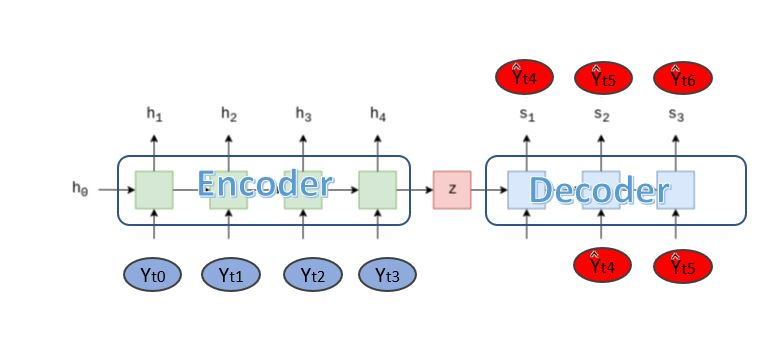

###### Resources 
* Pytorch toturial about various seq2seq models 

    https://github.com/bentrevett/pytorch-seq2seq
* Kaggle 1st place - eb-traffic-time-series-forecasting

  https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/43795
  
* Some of the ideas were taken from my previous kernel 

  https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data
  
* Notebook with Encoder-Decoder and Attention for Text translating - but a good example that I have used and converted to time series   
  https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb
  
  
  



#### Version 1  - Two Models 
#### Version 2-3 - Add TOC 
#### Version 4-6  Add Attention to the first example 
#### Version 7 Add illustrations  

## Table of Content 
* [<font size=4>One Time Series Model</font>](#1)
* [<font size=4>Select One Time Series as an Example</font>](#2)
* [<font size=4>Difference Transform</font>](#3)
* [<font size=4>Normlize/Scale Data</font>](#4)
* [<font size=4>Building the Seq2Seq Model</font>](#5)
* [<font size=4>Predict</font>](#6)
* [<font size=4>Add Features</font>](#7)


# One Time Series Model <a id="1"></a> 

# Load Libraries 

In [1]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import time 
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch 
from sklearn.model_selection import TimeSeriesSplit

from math import log
from math import exp
from scipy.stats import boxcox

 
import torch.optim as optim

%matplotlib inline

#from gensim.models import Word2Vec
#import gensim.downloader as api

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

 

ModuleNotFoundError: No module named 'dask'

## GPU 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is:",device)

device is: cuda


In [ ]:
INPUT_DIR_PATH = '../input/m5-forecasting-accuracy/'

# Read Date 

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def read_data():
    sell_prices_df = pd.read_csv(INPUT_DIR_PATH + 'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_validation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))

    submission_df = pd.read_csv(INPUT_DIR_PATH + 'sample_submission.csv')
    return sell_prices_df, calendar_df, sales_train_validation_df, submission_df

In [ ]:
_,  calendar_df, sales_train_validation_df, _ = read_data()

Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Sales train validation has 30490 rows and 1919 columns


## Date List
Here we create dates list, that will help later on to display the Time Series, with the right dates 

In [ ]:
#Create date index
date_index = calendar_df['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

# Select One Time Series as an Example <a id="2"></a>
Selecting one arbitrary Time Series 
At the first phase, it is easier to try,
learn and understand the concepts on 
one Time Series 

In [ ]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
sales_train_validation_df['item_store_id'] = sales_train_validation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales_train_validation_df.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = sales_train_validation_df['item_store_id'].values

#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)


DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


## Plot 

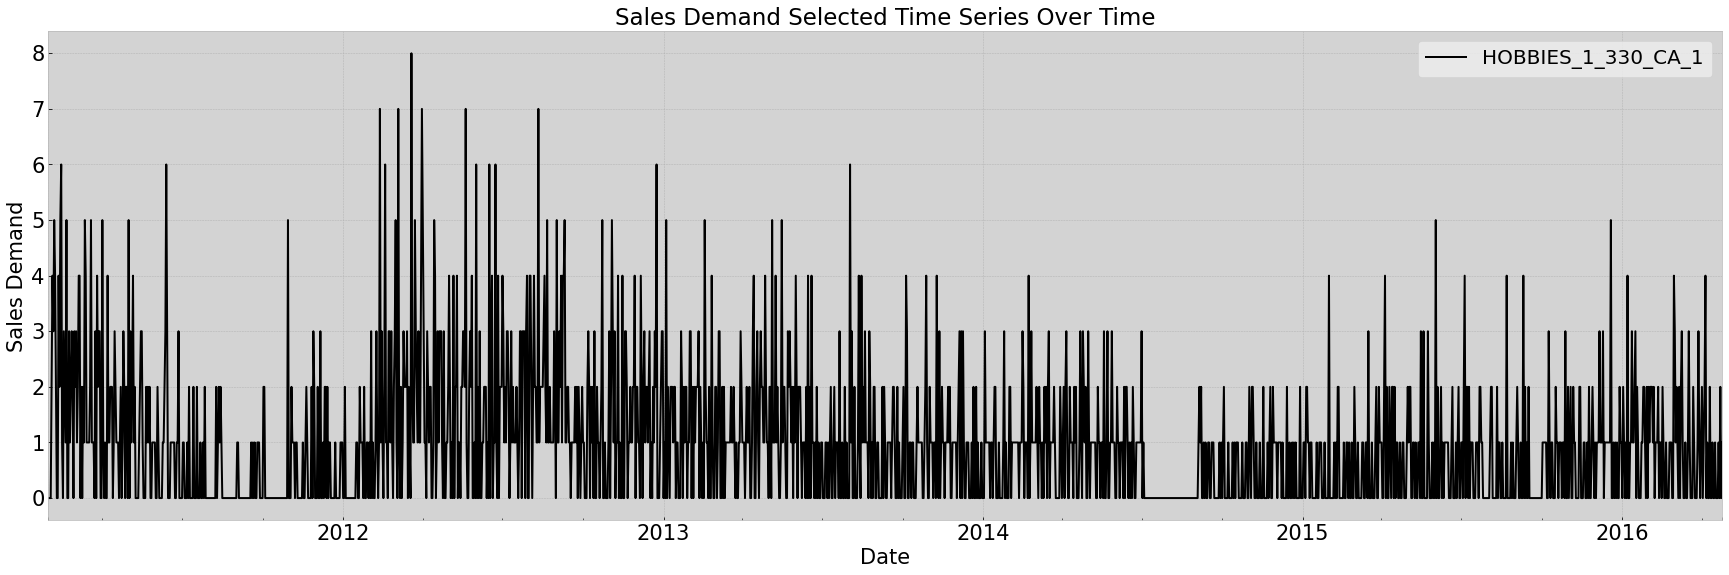

In [ ]:
#Select arbitrary index and plot the time series
index = 321
y = pd.DataFrame(DF_Sales.iloc[:,index])
TS_selected = y 
y = pd.DataFrame(y).set_index([dates_list])
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='black')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


## Seed All

In [ ]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

# Split Data 
We will split the Time Series into a training set and a validation set    
We will use all data except from the last 28 days as train and validation 
The last 28 days will be used for tests data


In [ ]:
train_size = int((len(TS_selected)-28) * 0.67)
valid_size = (len(TS_selected)-28)- train_size
print("train size is:",train_size)
print("validation size is:",valid_size)

train size is: 1262
validation size is: 623


In [ ]:
train_data = TS_selected.iloc[0:train_size,:]
valid_data = TS_selected.iloc[train_size:train_size+valid_size,:]
print("train data shape is:",train_data.shape)
print("validation data shape is:",valid_data.shape)


train data shape is: (1262, 1)
validation data shape is: (623, 1)


In [ ]:
train_data.head()

,HOBBIES_1_330_CA_1
2011-01-29,0
2011-01-30,0
2011-01-31,0
2011-02-01,0
2011-02-02,2


# Difference Transform <a id="3"></a>
A difference transform is a simple way for removing a systematic structure from the time series.

For example, a trend can be removed by subtracting the previous value from each value in the series. This is called first order differencing. The process can be repeated (e.g. difference the differenced series) to remove second order trends, and so on.

A seasonal structure can be removed in a similar way by subtracting the observation from the prior season, e.g. 12 time steps ago for monthly data with a yearly seasonal structure.

See this article 
https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/

Usually, it is good to clean Sesonabilty and trends from time series before we feed the data to the model 
As an illustration, I chose a simple time difference to transform for seven days 
But you can try a different days number  or use more complex statistical models to remove seasonable or trends 
The transform is done by 
Simple Difference transform  --> X(t)' = X(t) - X(t-7)


In [ ]:
## Simple Difference transform  --> X(t)' = X(t) - X(t-7)
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

np_tarin_data = train_data.iloc[:,0]
interval = 7 
transformed_train = difference(np_tarin_data, interval)

np_valid_data = valid_data.iloc[:,0]
interval = 7 
transformed_valid = difference(np_valid_data, interval)

train_data = np.array(transformed_train).reshape(len(transformed_train),1)
valid_data = np.array(transformed_valid).reshape(len(transformed_valid),1)

In [ ]:
train_data.shape

(1255, 1)

In [ ]:
valid_data.shape

(616, 1)

#  Normlize/Scale Data <a id="4"></a>
Scale or Normalization is a technique often applied as part of data preparation for machine learning.
The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values.
For machine learning, every dataset does not require normalization.
It is required only when features have different rangesor scales.



Normalizes our data using the min/max scaler with minimum and maximum values of -1 and 1, respectively

In [ ]:
scaler = MinMaxScaler((-1,1)).fit(train_data)
#scaler = StandardScaler().fit(train_data)
train_data_std = scaler.transform(train_data)
valid_data_std = scaler.transform(valid_data)

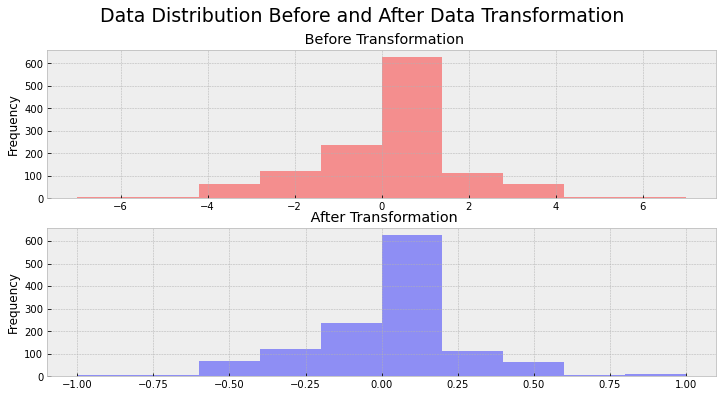

In [ ]:
fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Data Transformation   ',fontsize = 19)
pd.DataFrame(train_data).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Transformation',color ='red') 
pd.DataFrame(train_data_std).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Transformation'\
                                         ,color = 'blue')
   

## Normlize 
Anoter approach is normlize according to a rolling window 

## Create Sequance 
It is common not to feed the entire data to the network (to the encoder)
But to break it into sequences and windows as illustrated below 

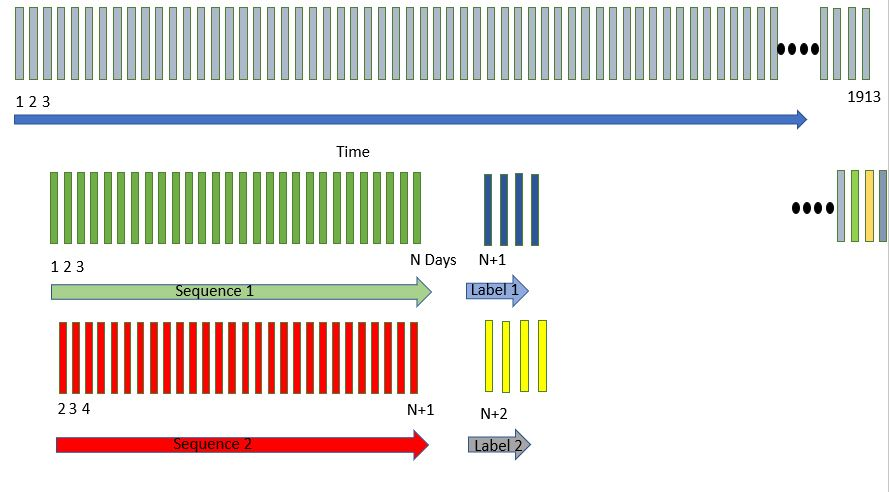

In [ ]:
###  This function creates a sliding window or sequences of seq_length days and labels_length  days label ####
def sliding_windows(data, seq_length,labels_length):
    x = []
    y = []

    for i in range(len(data)-(seq_length+labels_length)):
        _x = data[i:(i+seq_length)]
        _y = data[(i+seq_length):(i+seq_length+labels_length)]
        x.append(_x)
        y.append(_y)

    return x,y

We wil use a sliding window of 90 days 
Our target(labels) is 28 days

In [ ]:
seq_length = 90
labels_length =28
train_X, train_y = sliding_windows(train_data_std, seq_length,labels_length)
print("train X  has:", len(train_X) , "series")
print("train labels  has:", len(train_y) , "series")
valid_X, valid_y = sliding_windows(valid_data_std, seq_length,labels_length)
print("validiation  X  has:", len(valid_X) , "series")
print("Validiation  labels  has:" ,len(valid_y) , "series")

train X  has: 1137 series
train labels  has: 1137 series
validiation  X  has: 498 series
Validiation  labels  has: 498 series


## Plot Example 
To verify the concept 
Let's plot 
* The original TS (take the length of the sliding window + the label size - 90 days + 28 days)
* The first array of trainX - which is the first sequence
* The first array of trainy , which is the first label 

(-1.0, 1.0)

<Figure size 1080x1224 with 0 Axes>

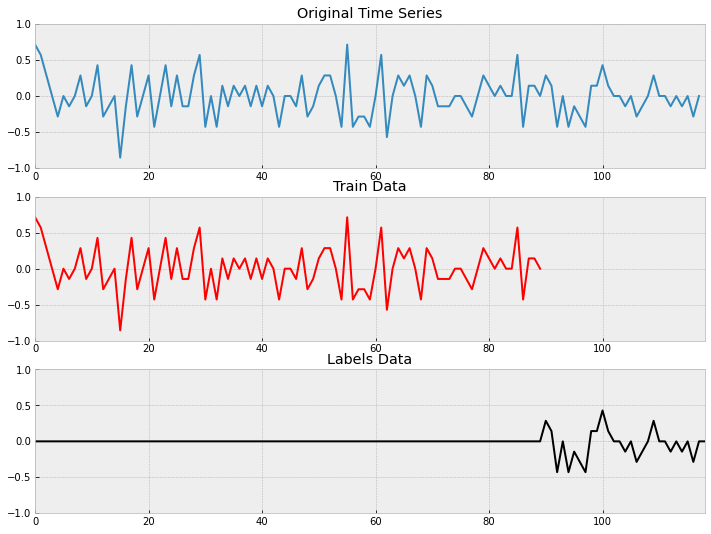

In [ ]:
plt.figure(figsize=(15,17))
fig, axs =plt.subplots(3,figsize=(12,9))

axs[0].plot(train_data_std[0:seq_length+labels_length])
axs[0].title.set_text('Original Time Series')
axs[0].set_xlim(0,seq_length+labels_length)
axs[0].set_ylim(-1,1)
axs[1].plot(train_X[0].flatten(),color="red")
axs[1].title.set_text('Train Data')
axs[1].set_xlim(0,seq_length+labels_length)
axs[1].set_ylim(-1,1)
axs[2].plot(np.pad(train_y[0].flatten(),seq_length),color='black')
axs[2].title.set_text('Labels Data')
axs[2].set_xlim(0,seq_length+labels_length)
axs[2].set_ylim(-1,1)


## Pytorch Tensors 
Pytorch use tensors as the input to the model 
Variable is a wrapper to the tensor 
This kernel is only a preliminary starter, 

So I use the Variable wrapper
A more common way is to train with batches and use the dataset class
But this is for later.

If you want to learn more about Tensors 
Read this tutorial 

https://pytorch.org/tutorials/beginner/former_torchies/tensor_tutorial.html

In [ ]:

trainX = Variable(torch.Tensor(train_X))
trainy = Variable(torch.Tensor(train_y))

validX = Variable(torch.Tensor(valid_X))
validy= Variable(torch.Tensor(valid_y))

print ("trainX shape is:",trainX.size())
print ("trainy shape is:",trainy.size())
print ("validX shape is:",validX.size())
print ("validy shape is:",validy.size())


trainX shape is: torch.Size([1137, 90, 1])
trainy shape is: torch.Size([1137, 28, 1])
validX shape is: torch.Size([498, 90, 1])
validy shape is: torch.Size([498, 28, 1])


# Building the Seq2Seq Model <a id="5"></a>

## Encoder

The Encoder structure is very similar to an LSTM/RNN network 
for sequence modeling/training.

The difference is that we output the Hidden and Cell states (cell in case of LSTM) 
of the last cell, as an output to  feed it to the decoder.




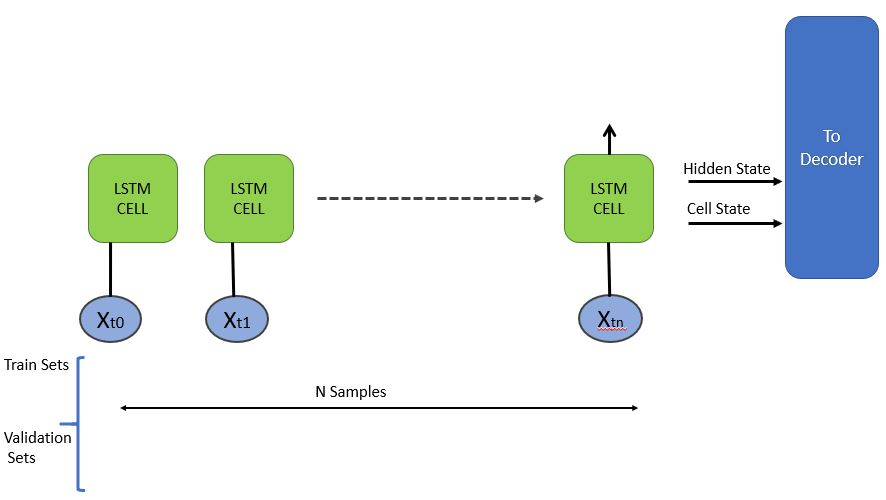

In [ ]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
   
    def forward(self, x):
       
        x = x.reshape((1, self.seq_len, self.n_features))
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
              
        x, (hidden, cell) = self.rnn1(x,(h_1, c_1))
        
        
        #return hidden_n.reshape((self.n_features, self.embedding_dim))
        return x, hidden , cell 

## Attention
This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.


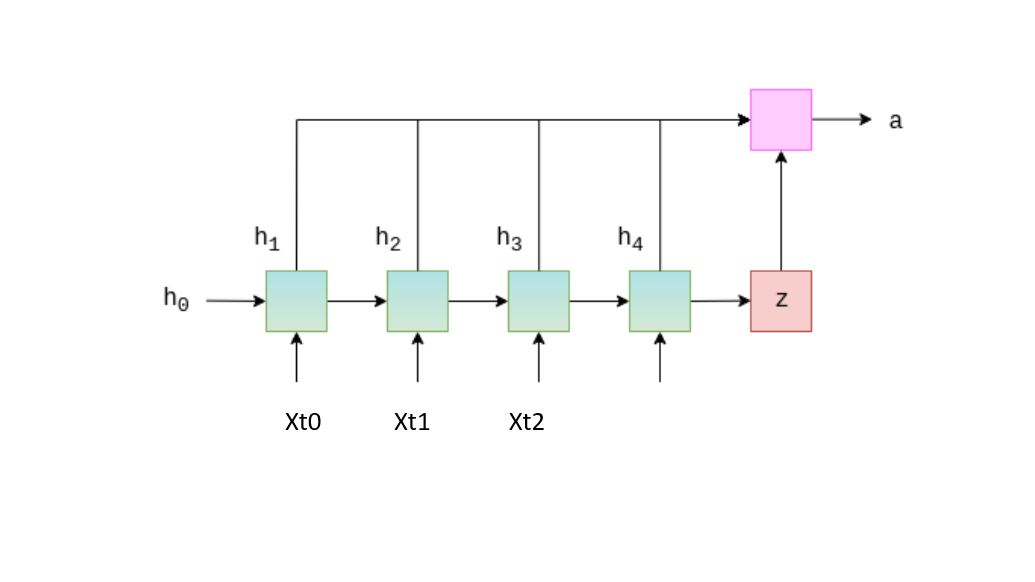

Image was taken from : 
https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim ) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
       
        hidden = hidden[2:3,:,:]
        
        #print("hidden size is",hidden.size())
        
        
        
        #repeat decoder hidden state src_len times
        #hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        hidden = hidden.repeat(1, src_len, 1)
     
        
        #encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #print("encode_outputs size after permute is:",encoder_outputs.size())
        
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        
        return F.softmax(attention, dim=1)

## Decoder 
The Decoder is a bit more tricky part 
* We feed the Hidden state and the cell state of the last cell of the Encoder
* We use RNN (in this case LSTM)
* We predict using the first cell, and then we iterate (using our prediction)
        to create N-1 more predictions (in this case overall of 28 TS samples)
* It also use the Attention layer 


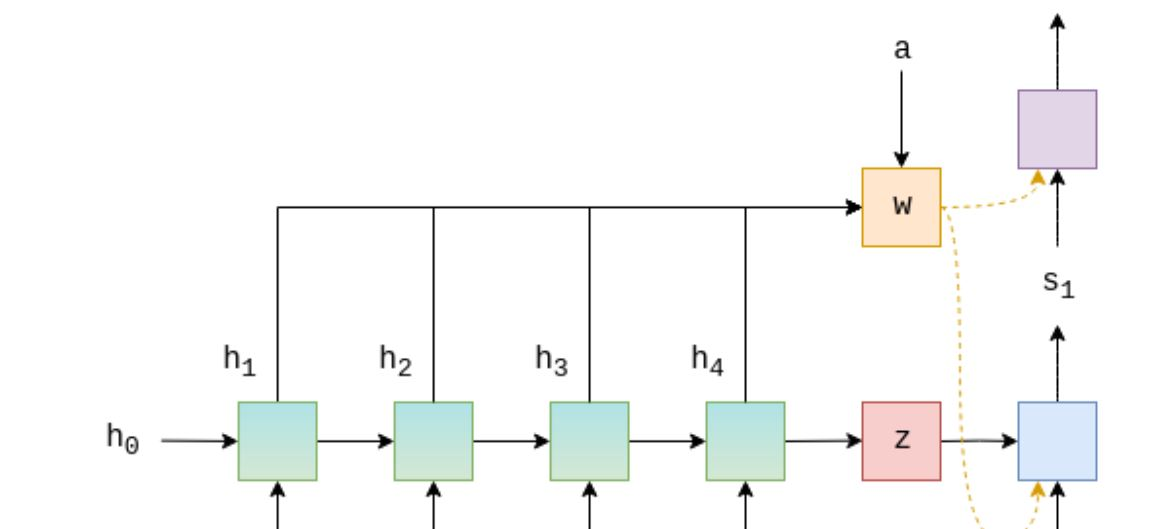

In [ ]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        
        self.rnn1 = nn.LSTM(
          input_size=1,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x,input_hidden,input_cell):
       
       
        x = x.reshape((1,1,1))
        
        
     

        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
    
        x = self.output_layer(x)
        return x, hidden_n, cell_n

## Attention Decoder 

In [ ]:
class AttentionDecoder(nn.Module):
    def __init__(self, seq_len,attention, input_dim=64, n_features=1,encoder_hidden_state = 512):
        super(AttentionDecoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        self.attention = attention 
        
        self.rnn1 = nn.LSTM(
          #input_size=1,
          input_size= encoder_hidden_state + 1,  # Encoder Hidden State + One Previous input
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim * 2 , n_features)

    def forward(self, x,input_hidden,input_cell,encoder_outputs):
       
        a = self.attention(input_hidden, encoder_outputs)
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        #encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
      
        
        weighted = torch.bmm(a, encoder_outputs)
        
        
     
        x = x.reshape((1,1,1))
       
        
        
        rnn_input = torch.cat((x, weighted), dim = 2)
       

        #x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
        x, (hidden_n, cell_n) = self.rnn1(rnn_input,(input_hidden,input_cell))
        
        output = x.squeeze(0)
        weighted = weighted.squeeze(0)
        
        x = self.output_layer(torch.cat((output, weighted), dim = 1))
        return x, hidden_n, cell_n
    
      

## Seq2Seq

In [ ]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length = 28):
        super(Seq2Seq, self).__init__()

        
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.attention = Attention(512,512)
        self.output_length = output_length
        self.decoder = AttentionDecoder(seq_len, self.attention, embedding_dim, n_features).to(device)
        

    def forward(self,x, prev_y):
        
        encoder_output,hidden,cell = self.encoder(x)
         
        #Prepare place holder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        prev_output = prev_y
        
        #itearate over LSTM - according to the required output days
        for out_days in range(self.output_length) :
        
            prev_x,prev_hidden,prev_cell = self.decoder(prev_output,hidden,cell,encoder_output)
            hidden,cell = prev_hidden,prev_cell
            prev_output = prev_x
            
            targets_ta.append(prev_x.reshape(1))
           
            
        
        
        targets = torch.stack(targets_ta)

        return targets

In [ ]:
n_features = 1
model = Seq2Seq(seq_length, n_features, 512)
model = model.to(device)

In [ ]:
model

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (attention): Attention(
    (attn): Linear(in_features=1024, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (decoder): AttentionDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (rnn1): LSTM(513, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (attention): Attention(
    (attn): Linear(in_features=1024, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (decoder): AttentionDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (rnn1): LSTM(513, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3,weight_decay=1e-5)
criterion = torch.nn.MSELoss().to(device) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=10, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [31]:
def train_model(model, TrainX,Trainy,ValidX,Validy,seq_length, n_epochs):
  
    history = dict(train=[], val=[])

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    mb = master_bar(range(1, n_epochs + 1))

    for epoch in mb:
        model = model.train()

        train_losses = []
        for i in progress_bar(range(TrainX.size()[0]),parent=mb):
            seq_inp = TrainX[i,:,:].to(device)
            seq_true = Trainy[i,:,:].to(device)
           
            optimizer.zero_grad()

            
            seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])
            
            
            loss = criterion(seq_pred, seq_true)

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for i in progress_bar(range(validX.size()[0]),parent=mb):
                seq_inp = ValidX[i,:,:].to(device)
                seq_true = Validy[i,:,:].to(device)
        
                seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])
               

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            print("saved best model epoch:",epoch,"val loss is:",val_loss)
        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        scheduler.step()
    #model.load_state_dict(best_model_wts)
    return model.eval(), history

In [ ]:
model, history = train_model(
  model,
  trainX,trainy,
  validX,validy,
  seq_length,
  n_epochs=30, ## Training only on 30 epochs to save GPU time 
    
)

saved best model epoch: 1 val loss is: 0.03500368754121374
Epoch 1: train loss 0.10939238280452716 val loss 0.03500368754121374
saved best model epoch: 2 val loss is: 0.03487704365502998
Epoch 2: train loss 0.056559886021593626 val loss 0.03487704365502998
Epoch 3: train loss 0.06568884335764624 val loss 0.03589363196625348
Epoch 4: train loss 0.056940699798090216 val loss 0.040278538421963356
Epoch 5: train loss 0.08471732579373158 val loss 0.03618653541819817
Epoch 6: train loss 0.056740055771556046 val loss 0.036135149205170844
Epoch 7: train loss 0.0843745161858678 val loss 0.0379122537635566
Epoch 8: train loss 0.056753564263933985 val loss 0.040909112103836964
Epoch 9: train loss 0.05721106815312415 val loss 0.03722125424042225
Epoch 10: train loss 0.056825874637887734 val loss 0.036132701515523065
Epoch 11: train loss 0.057547727627589605 val loss 0.036388784850831614
Epoch 12: train loss 0.05685985855972796 val loss 0.036737512933636404
Epoch 13: train loss 0.05823088925669302 

# Predict <a id="6"></a>
To illustrate the  model let's take, the last 28 days available as our target for prediction 
and the previous 90 days as the input to the model 
We take it from the original series, and we need to issue the transformation again 

In [ ]:
TestX = np.array(TS_selected.iloc[-118:-28:,:])
Testy = np.array(TS_selected.iloc[-28:,:])
TestX = Variable(torch.Tensor(TestX))
 

In [ ]:
TestX_Diff = difference(TestX, interval)
TestX_Diff_Norm = scaler.transform(np.array(TestX_Diff).reshape(len(TestX_Diff),1))

In [ ]:
######Prediction###############
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    seq_inp = TestX.to(device)
    
        
    seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])
          


 ## Inverse Normalise 

In [ ]:
data_predict = scaler.inverse_transform(seq_pred.cpu().numpy())
labels = Testy

## Inverse Difference transform 
This one is more tricky, and we need to do the following. 

* X(t)  = X(t)' + X(t-7)  
* x(t)'  is the sample after the iffernce transformaition at time 
* X(t) is regular sample at time t 
* x(t-7) is the regular sample at current time minus 7 days 
* The Diff formula is 
* X(t)'  = X(t) - X(t-7)
* We want X(t) now so 

* X(t) = X(t)' + X(t-7) 
* conctnate the original 90 days (input) to the prediction (which is in diff transform domain) , 
use the formula to update all predicted 28 days 


In [ ]:
orignal_data = np.array(TS_selected.iloc[-118:-28:,:]).flatten()
pred = data_predict.flatten()
orig_pred = np.concatenate([orignal_data,pred])


In [ ]:
time_diff = 7 
inv_pred = np.zeros((28))
for  index in range(28):
    inv_pred[index] = orig_pred[90+index]+ orig_pred[90+index-7]
    orig_pred[90+index] = inv_pred[index]


In [ ]:
data_predict= np.array(inv_pred)
data_predict = np.where(data_predict<0,0,data_predict)


In [ ]:
## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[-28:]])
df_labels = pd.DataFrame(labels)
df_labels = df_labels.set_index([dates_list[-28:]])

# Plot 
figure(num=None, figsize=(24, 6), dpi=80, facecolor='w', edgecolor='k')
#plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Time Series','Prediction'],fontsize = 21)
plt.suptitle('Time-Series Prediction Last 28 Days',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


## RMSE 

In [ ]:
np.sqrt(((data_predict - labels) ** 2).mean())

# Add Features <a id="7"></a>
So far we add only one feature - The Sales demand 
Now  let's  more features 
We will add more dimension to the input 
and we will feed it both to the Encoder and the decoder 


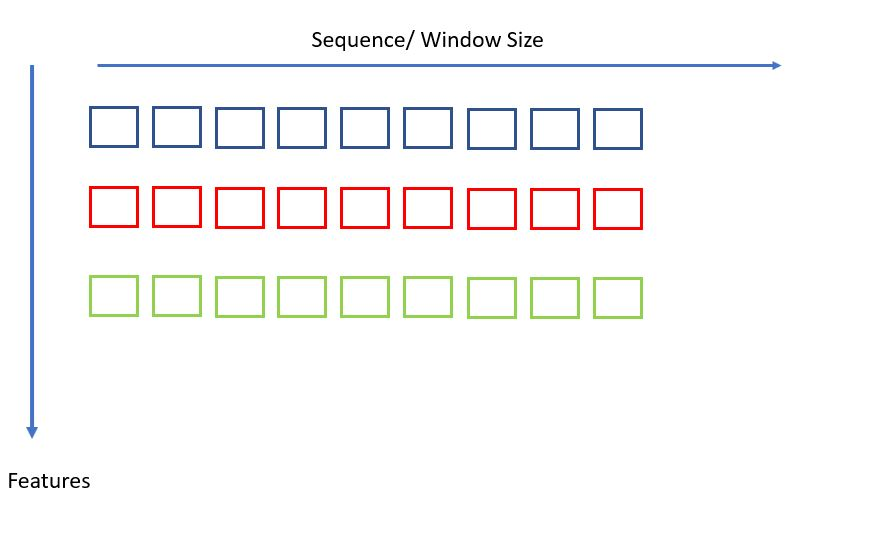

Features can be lags or rolling windows 
It is easier to implement using data-frame
Lag is just shifting the sales demand.

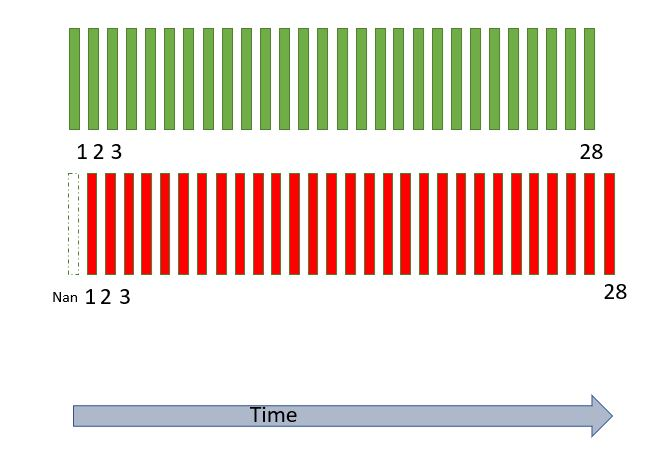

Rolling window is some calculation over a window (example mean , std  )

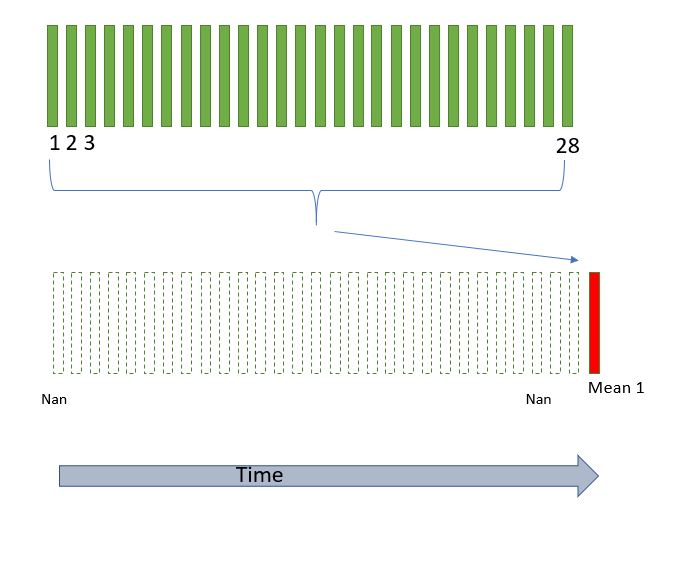

To do the manipulation and add the features it is easier to work with a pandas Data frame 
So we will return our Selected time series into a data frame. 

In [ ]:
DF = TS_selected
colnames = DF.columns
DF = DF.rename(columns={colnames[0]:'sales'})
DF.tail()

# Transformiation 

In [ ]:
## Simple Difference transform  --> X(t)' = X(t) - X(t-7)

def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

transformed_data = difference(DF['sales'], interval)
DF = DF.iloc[7:,:]
DF['orig_sales'] = DF['sales']
DF['sales'] = transformed_data
DF.shape

In [ ]:
start_time = time.time()
for i in (1,7,14,28,365):
    print('Shifting:', i)
    DF['lag_'+str(i)] = DF['sales'].transform(lambda x: x.shift(i))
print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))


In [ ]:
for i in [7,14,28,60,180,365]:
    print('Rolling period:', i)
    DF['rolling_mean_'+str(i)] = DF['orig_sales'].transform(lambda x: x.shift(28).rolling(i).mean())
    DF['rolling_std_'+str(i)]  = DF['orig_sales'].transform(lambda x: x.shift(28).rolling(i).std())


print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))
DF.head()

In [ ]:
DF = DF.replace('nan', np.nan).fillna(0)
DF.head()

## Normlize 

In [ ]:
DF = DF.drop('orig_sales',1)
DF_normlized = DF.copy(deep=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(DF) 
y_scaler.fit_transform(DF['sales'].values.reshape(-1, 1))
DF_normlized.iloc[:,:] =  scaled_data
   

DF_normlized.head()

# Split Data 
Again We will split the data into a training set and a validation set    
We will use all data except from the last 28 days as train and validation 
The last 28 days will be used for tests data


In [ ]:
train_size = int((DF_normlized.shape[0]-28) * 0.67)
valid_size = (DF_normlized.shape[0]-28)- train_size
print("train size is:",train_size)
print("validation size is:",valid_size)
train_data = DF_normlized.iloc[0:train_size,:]
valid_data = DF_normlized.iloc[train_size:train_size+valid_size,:]
print("train data shape is:",train_data.shape)
print("validation data shape is:",valid_data.shape)


## Multi-Dimensional Sliding Window

In [ ]:
###  This function creates a sliding window or sequences of seq_length days and labels_length  days label ####
def sliding_windows(data, seq_length,labels_length):
    x = []
    y = []
    z = []

    for i in range(len(data)-(seq_length+labels_length)):
        _x = data.iloc[i:(i+seq_length),:]
        _y = data.iloc[(i+seq_length):(i+seq_length+labels_length),0:1]
        _z  = data.iloc[(i+seq_length):(i+seq_length+labels_length),1:]
        x.append(np.array(_x))
        y.append(np.array(_y))
        z.append(np.array(_z))

    return x,y,z

We wil use a sliding window of 90 days 
Our target(labels) is 28 days

In [ ]:
seq_length = 90
labels_length =28
train_X, train_y,train_features = sliding_windows(train_data, seq_length,labels_length)
print("train X  has:", len(train_X) , "series")
print("train labels  has:", len(train_y) , "series")
valid_X, valid_y,valid_features = sliding_windows(valid_data, seq_length,labels_length)
print("validiation  X  has:", len(valid_X) , "series")
print("Validiation  labels  has:" ,len(valid_y) , "series")

In [ ]:
train_X[0].shape

In [ ]:
train_y[0].shape

In [ ]:
train_features[0].shape

## Convert to Pytorch Tensors 

In [ ]:
trainX = Variable(torch.Tensor(train_X))
trainy = Variable(torch.Tensor(train_y))
train_features = Variable(torch.Tensor(train_features))
validX = Variable(torch.Tensor(valid_X))
validy= Variable(torch.Tensor(valid_y))
valid_features = Variable(torch.Tensor(valid_features))


print ("trainX shape is:",trainX.size())
print ("trainy shape is:",trainy.size())
print ("train features  shape is:",train_features.size())
print ("validX shape is:",validX.size())
print ("validy shape is:",validy.size())
print ("valid features  shape is:",valid_features.size())


# Seq2Seq Model 
The model needs to be adjusted 
The main difference is that the decoder input is also fed with the N features (except the previous prediction)

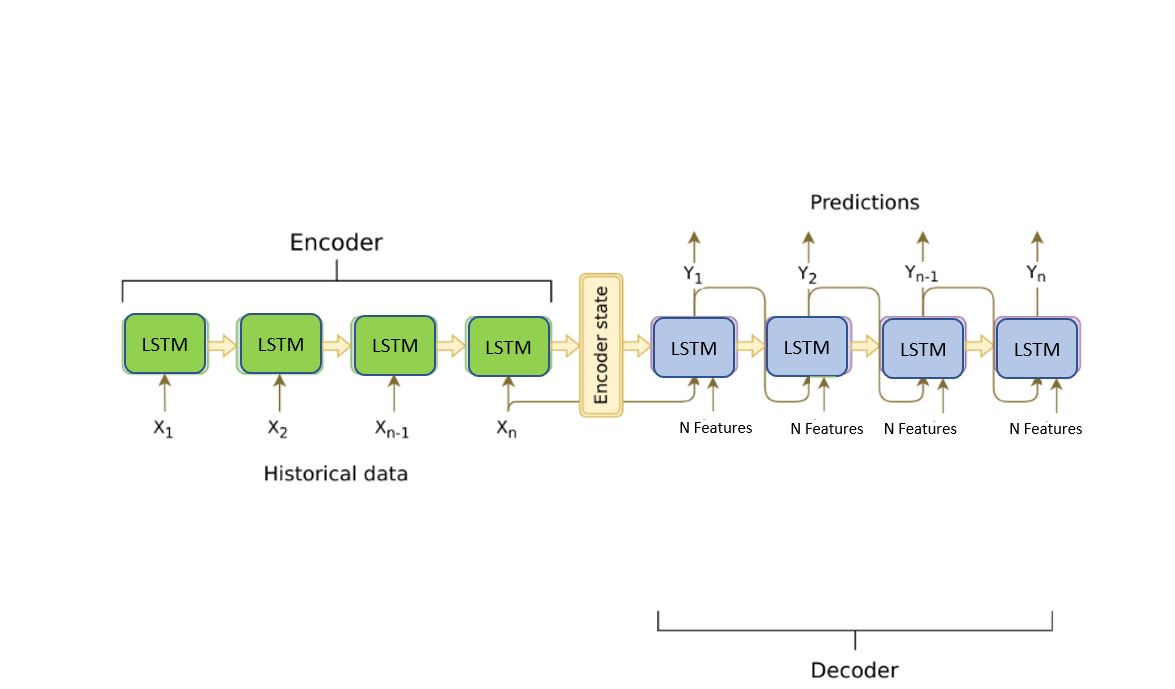

## Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
   
    def forward(self, x):
       
        x = x.reshape((1, self.seq_len, self.n_features))
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
              
        x, (hidden, cell) = self.rnn1(x,(h_1, c_1))
        
        
        #return hidden_n.reshape((self.n_features, self.embedding_dim))
        return hidden , cell 

## Decoder 

In [ ]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x,input_hidden,input_cell):
       
       
        x = x.reshape((1,1,self.n_features ))
        #print("decode input",x.size())
             

        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
    
        x = self.output_layer(x)
        return x, hidden_n, cell_n

## Seq2Seq

In [ ]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length = 28):
        super(Seq2Seq, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.n_features = n_features
        self.output_length = output_length
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        

    def forward(self,x, prev_y,features):
        
       
        hidden,cell = self.encoder(x)
         
        #Prepare place holder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        dec_input = prev_y
        
        
        
       #dec_input = torch.cat([prev_output, curr_features], dim=1) 
        
        #itearate over LSTM - according to the required output days
        for out_days in range(self.output_length) :
            
          
            prev_x,prev_hidden,prev_cell = self.decoder(dec_input,hidden,cell)
            hidden,cell = prev_hidden,prev_cell
            
            prev_x = prev_x[:,:,0:1]
            #print("preve x shape is:",prev_x.size())
            #print("features shape is:",features[out_days+1].size())
            
            if out_days+1 < self.output_length :
                dec_input = torch.cat([prev_x,features[out_days+1].reshape(1,1,17)], dim=2) 
            
            targets_ta.append(prev_x.reshape(1))
           
            
        
        
        targets = torch.stack(targets_ta)

        return targets

In [ ]:
n_features = trainX.shape[2]
model = Seq2Seq(seq_length, n_features, 512)
model = model.to(device)
model

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

In [ ]:
def train_model(model, TrainX,Trainy,ValidX,Validy,seq_length, n_epochs):
  
    history = dict(train=[], val=[])

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    mb = master_bar(range(1, n_epochs + 1))

    for epoch in mb:
        model = model.train()

        train_losses = []
        for i in progress_bar(range(TrainX.size()[0]),parent=mb):
            seq_inp = TrainX[i,:,:].to(device)
            seq_true = Trainy[i,:,:].to(device)
            features = train_features[i,:,:].to(device)
           
            optimizer.zero_grad()

            
            seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],features)
            
            
            loss = criterion(seq_pred, seq_true)

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for i in progress_bar(range(validX.size()[0]),parent=mb):
                seq_inp = ValidX[i,:,:].to(device)
                seq_true = Validy[i,:,:].to(device)
                features = valid_features[i,:,:].to(device)
        
                seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],features)
               

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model_n_features.pt')
            print("saved best model epoch:",epoch,"val loss is:",val_loss)
        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        scheduler.step(val_loss)
    #model.load_state_dict(best_model_wts)
    return model.eval(), history

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2,weight_decay=1e-5)
criterion = torch.nn.MSELoss().to(device) 
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=10, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [ ]:
model, history = train_model(
  model,
  trainX,trainy,
  validX,validy,
  seq_length,
  n_epochs=10, #Train for few epochs as illustration, 
    
)

# Predict 

In [ ]:
TestX = np.array(TS_selected.iloc[-700:-28:,:]).flatten()
Testy = np.array(TS_selected.iloc[-28:,:])


TestX.shape

In [ ]:

def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

transformed_data = difference(TestX, interval)
DF = pd.DataFrame()
DF['sales'] = transformed_data
DF['orig_sales'] = TestX[7:]
DF.head(10)

In [ ]:
for i in (1,7,14,28,365):
    print('Shifting:', i)
    DF['lag_'+str(i)] = DF['sales'].transform(lambda x: x.shift(i))
print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))


In [ ]:
for i in [7,14,28,60,180,365]:
    print('Rolling period:', i)
    DF['rolling_mean_'+str(i)] = DF['orig_sales'].transform(lambda x: x.shift(28).rolling(i).mean())
    DF['rolling_std_'+str(i)]  = DF['orig_sales'].transform(lambda x: x.shift(28).rolling(i).std())


print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))
DF.head()

In [ ]:
DF = DF.drop('orig_sales', 1)


DF_normlized = DF.copy(deep=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(DF) 
y_scaler.fit_transform(DF['sales'].values.reshape(-1, 1))
DF_normlized.iloc[:,:] =  scaled_data
DF_normlized = DF_normlized.iloc[-90:,:]
TestX = Variable(torch.Tensor(np.array(DF_normlized)))

In [ ]:
TestX

In [ ]:
######Prediction###############
model.load_state_dict(torch.load('../input/seq2seq-simple-model/best_model_n_features.pt'))
model.eval()

with torch.no_grad():
    seq_inp = TestX.to(device)
    
        
    seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],seq_inp[:,1:])
          


In [ ]:
seq_pred.shape

In [ ]:
data_predict = y_scaler.inverse_transform(seq_pred.cpu().numpy())
labels = Testy

In [ ]:
orignal_data = np.array(TS_selected.iloc[-118:-28:,:]).flatten()
pred = data_predict.flatten()
orig_pred = np.concatenate([orignal_data,pred])


In [ ]:
time_diff = 7 
inv_pred = np.zeros((28))
for  index in range(28):
    inv_pred[index] = orig_pred[90+index]+ orig_pred[90+index-7]
    orig_pred[90+index] = inv_pred[index]


In [ ]:
data_predict

In [ ]:
data_predict= np.array(inv_pred)
#data_predict = np.where(data_predict<0,0,data_predict)


In [ ]:
## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[-28:]])
df_labels = pd.DataFrame(labels)
df_labels = df_labels.set_index([dates_list[-28:]])

# Plot 
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
#plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Time Series','Prediction'],fontsize = 21)
plt.suptitle('Time-Series Prediction 28 Days',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


## RMSE 

In [ ]:
np.sqrt(((data_predict - labels) ** 2).mean())